

*   Cynthia Cho
*   CSC 578-701 Loop
*   Final Project - Kaggle


---



*    **Kaggle user name: cindy**
*    **Public ranking/score: 18 / 1.65827**
*    **Private ranking/score: 17 / 1.66435**

# **Table of Contents**



*   Importing Libraries
*   Data Load
*   ->Function for converting data into time series data
*   ->Function for creating graphs of the loss and MSE
*   Exploratory Analysis
*   Restructuring, Splitting, and Scaling the data
*   Models (1-4)
*   Conclusion (see final paper)

Import Libraries

In [0]:
import csv
import time
import pandas as pd
import numpy as np
import pickle
from pandas import DataFrame
from pandas import concat
from pylab import rcParams



from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import Adam, SGD, RMSprop


from keras.layers import CuDNNLSTM, Conv1D, Flatten, CuDNNGRU, LeakyReLU
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, GRU

from sklearn.model_selection import train_test_split

## **Data Load**

In [16]:
# loading the data
df=pd.read_csv('climate_hour.csv', header=0)
df.head(), df.shape

(             Date Time  p (mbar)  T (degC)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
 0  01.01.2009 01:00:00    996.50     -8.05  ...      0.21           0.63     192.7
 1  01.01.2009 02:00:00    996.62     -8.88  ...      0.25           0.63     190.3
 2  01.01.2009 03:00:00    996.84     -8.81  ...      0.18           0.63     167.2
 3  01.01.2009 04:00:00    996.99     -9.05  ...      0.10           0.38     240.0
 4  01.01.2009 05:00:00    997.46     -9.63  ...      0.40           0.88     157.0
 
 [5 rows x 15 columns], (70037, 15))

Below we are subsetting the data for the four variables that will be used in this project.  We are also truncating the first 54 values for Y since we are looking to predict 6 hours ahead.

In [0]:
df_modified = df[['T (degC)','p (mbar)', 'rho (g/m**3)', 'wv (m/s)']]
Y = df[['T (degC)']].iloc[53:]

### Function for converting data into time series data
Restructures the data so that lags are concatenated.

In [0]:

def time_series_restructure(data, n_in=1, n_out=1, dropnan=True):
    """
    Converting a dataset into a time series dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('h%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('h%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('h%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

        return agg

### Function for creating graphs of the loss and accuracy
After each model is run, graphs are created to show how the model performed.

In [0]:
def plot_model_history(model_history):
    """ function plots the MSE and Loss for a model"""
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for Mean Square Square
    axs[0].plot(range(1,len(model_history.history['mean_squared_error'])+1),model_history.history['mean_squared_error'], 'g')
    axs[0].plot(range(1,len(model_history.history['val_mean_squared_error'])+1),model_history.history['val_mean_squared_error'], 'm')
    axs[0].set_title('Model Mean Square Error')
    axs[0].set_ylabel('MSE')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['mean_squared_error'])+1),len(model_history.history['mean_squared_error'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for Loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'], 'g')
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'], 'm')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()



---



## **Exploratory Data Analysis**

In [0]:
# Data for EDA
df_EDA = df[['Date Time','T (degC)','p (mbar)', 'rho (g/m**3)', 'wv (m/s)']]

In [21]:
# shows statistics
df_EDA.describe()

,T (degC),p (mbar),rho (g/m**3),wv (m/s)
count,70037.000000,70037.000000,70037.000000,70037.000000
mean,9.441694,989.214407,1216.101047,1.701543
std,8.420257,8.360583,39.964559,65.472610
min,-22.760000,918.500000,1066.190000,-9999.000000
25%,3.350000,984.200000,1187.560000,0.990000
50%,9.410000,989.580000,1213.850000,1.760000
75%,15.460000,994.730000,1242.850000,2.860000
max,37.280000,1015.290000,1392.560000,12.580000


In [22]:
# Check for missing data, and we can conclude that we are not missing data
df_EDA.isnull().sum()

Date Time       0
T (degC)        0
p (mbar)        0
rho (g/m**3)    0
wv (m/s)        0
dtype: int64

   

---



Below is a time plot of the four variables ('p (mbar)', 'T (degC)', 'rho (g/m**3)', 'wv (m/s)') that will be used in the project.

What is noticeable is that there is no trend but there is seasonality in the    T(degC) and rho(g/m**3) variables.  The trend is absent since the temperature does not immediately show any type of increasing/decreasing movement as the time plot increases.  However, seasonality can be seen from the cyclical pattern that is shown below.

With p(mbar) and wv(m/s) we do not see any type of discernable patter, however, there is a large dip that takes place with wv(m/s) towards the latter time period.

Something worth mentioning is the long spike shown for the wv(m/s) graph that appears to be an outlier within the dataset.  The outlier was not removed and kept in the dataset.

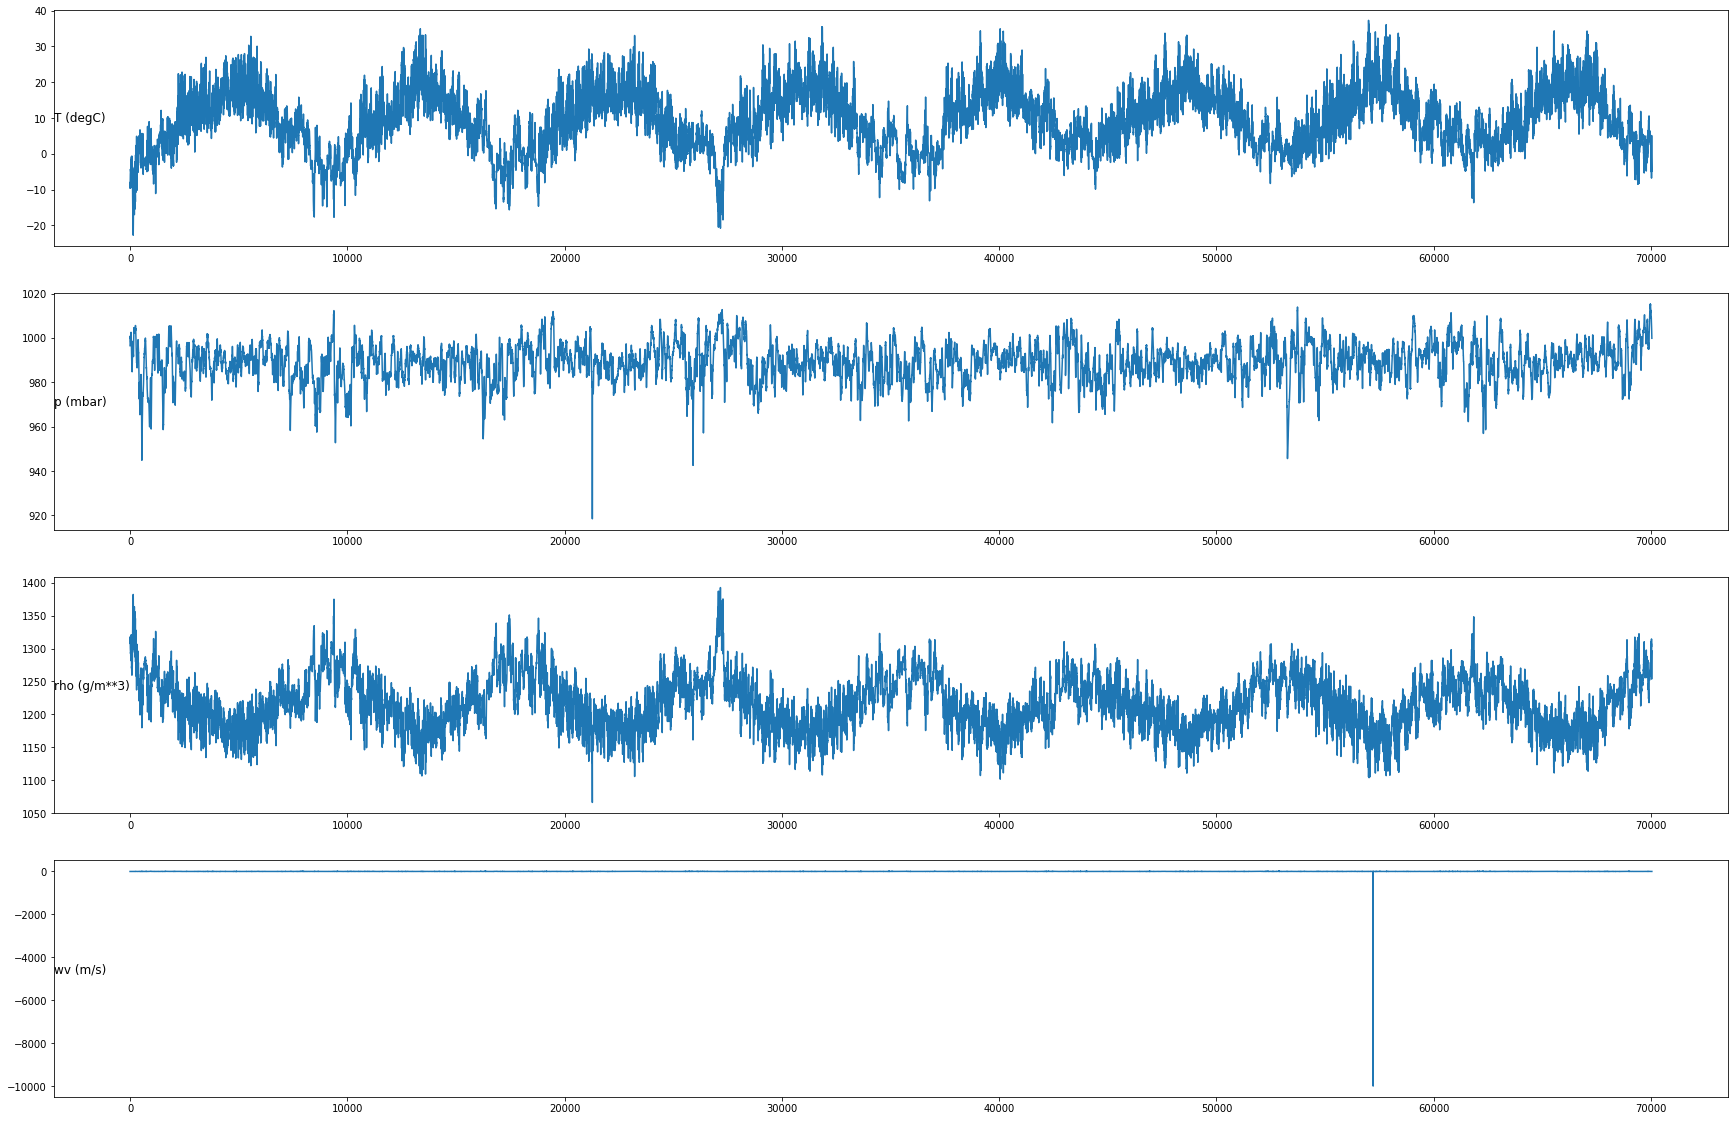

In [23]:
values = df_EDA.values
# specify columns to plot
groups = [1, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_EDA.columns[group], y=.5, loc='left')
    i += 1
plt.show()



---



The histograms below show that there is some normality to the graph with the exception of the wv(m/s) variable.  What the histogram for the T(degC) tells us that because it looks approximately normal, using the Mean Absolute Error for the loss function is approrpiate.

The histograms also exhibit signs of kurtosis, especially in the graphs for rho and p.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


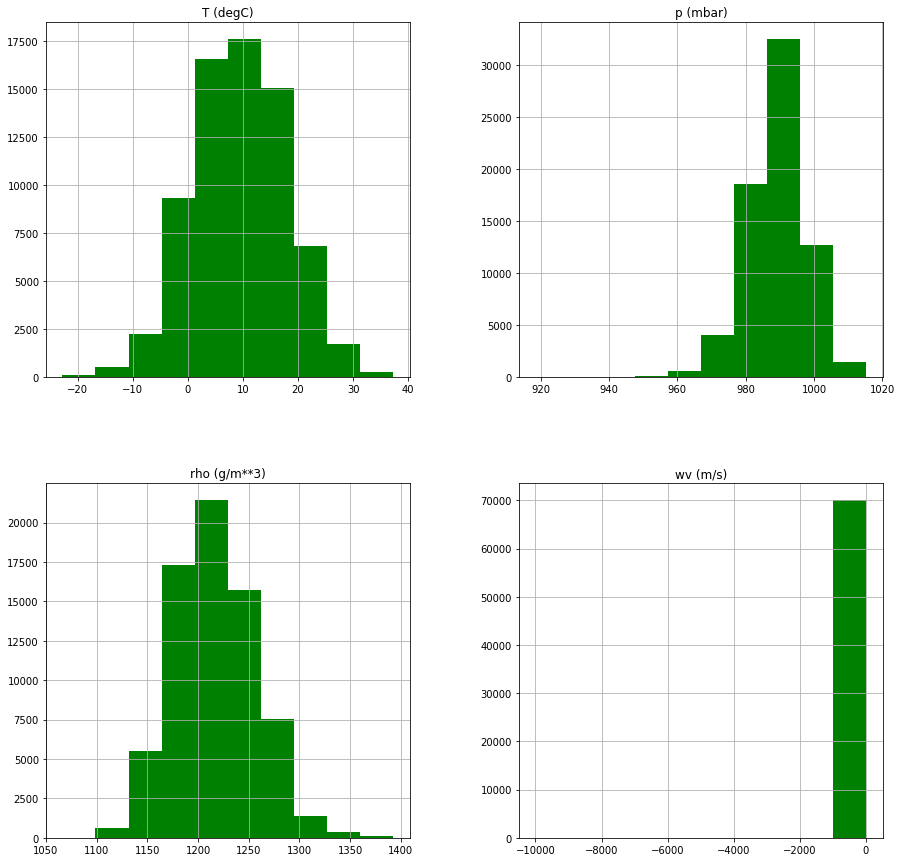

In [24]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df_EDA.hist(ax=ax, color= 'g')
plt.show()



---



The following charts provide additional statistics behind the four variables chosen for the project, and an additional correlation matrix.  

In [55]:
#import pandas_profiling
pandas_profiling.ProfileReport(df_modified)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,4
Number of observations,70037
Total Missing (%),0.0%
Total size in memory,2.1 MiB
Average record size in memory,32.0 B
Numeric,4
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0




---



## **Restructuring, splitting, and scaling the data**
*   Restructing the data to concatenate 48 rows (4 features a row) of data into one row
*   Splitting X and Y to x_training, x_test and y_training, y_test
*   Then splitting the x_training for train and validation
*   The data will be scaled using the Standard Scaler fitted for the x_train, and applied to the x_validation and x_test set.





In [0]:
# Getting the X data to suitable format and removing the last 6 rows that have no corresponding Y value
X = time_series_restructure(df_modified, 47, 1)
X = X.iloc[:69984]

Here we are reindexing the columns of X and Y

In [26]:
# Reindex X to start from 1 and not 0 or 48
X['idx'] = range(1,len(X)+1)
X.set_index('idx', inplace=True)
print(X.columns)

Index(['h1(t-47)', 'h2(t-47)', 'h3(t-47)', 'h4(t-47)', 'h1(t-46)', 'h2(t-46)',
       'h3(t-46)', 'h4(t-46)', 'h1(t-45)', 'h2(t-45)',
       ...
       'h3(t-2)', 'h4(t-2)', 'h1(t-1)', 'h2(t-1)', 'h3(t-1)', 'h4(t-1)',
       'h1(t)', 'h2(t)', 'h3(t)', 'h4(t)'],
      dtype='object', length=192)


In [0]:
# Reindex Y to start from 1 to ensure it lines up with X
Y['idx'] = range(1,len(Y)+1)
Y.set_index('idx', inplace=True)


*   The splitting of the dataset was initially done manually to follow the instructions of the homework where training and testing was split 48000:21984.


*   The first split is done to split X into training and test set.  Then the training is further split into train and validation.  The same is done for Y.




In [28]:
# Split
x_training, y_training, x_test, y_test = X.iloc[:48000], Y.iloc[:48000], X.iloc[48000:], Y.iloc[48000:]
x_train, x_valid, y_train, y_valid = train_test_split(x_training, y_training,test_size=0.2, shuffle=False)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((38400, 192), (38400, 1), (9600, 192), (9600, 1), (21984, 192), (21984, 1))

For the final scaler, I used the Standard Scaler because it worked better in the end with the data.

In [0]:
#scaler = MinMaxScaler(feature_range=(-1,  1))
scaler = StandardScaler()
scaler.fit(x_train)
scale_x_train = scaler.transform(x_train)
scale_x_valid = scaler.transform(x_valid)
scale_x_test = scaler.transform(x_test)

In [32]:
# Reshaping the input data to feed into the RNN models
scale_x_train=scale_x_train.reshape(scale_x_train.shape[0], 48, 4)
scale_x_valid=scale_x_valid.reshape(scale_x_valid.shape[0], 48, 4)
scale_x_test=scale_x_test.reshape(scale_x_test.shape[0], 48, 4)
scale_x_train.shape, scale_x_valid.shape, scale_x_test.shape

((38400, 48, 4), (9600, 48, 4), (21984, 48, 4))



---



## **Models**
Except for the base model which is only a single model, the other 3 have multiple versions and the best version was selected based not only on performance but other factors as time and spread.

*   Model 1 (base model)
*   Model 2 (LSTM)
*   Model 3 (1D Convnet + LSTM)
*   Model 4 (GRU)

#### **Base Model**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 9s 230us/step - loss: 4.6881 - mean_squared_error: 36.5256 - val_loss: 5.2519 - val_mean_squared_error: 41.5037
Epoch 2/50
38400/38400 [==============================] - 8s 196us/step - loss: 3.3656 - mean_squared_error: 19.8476 - val_loss: 3.9081 - val_mean_squared_error: 24.0886
Epoch 3/50
38400/38400 [==============================] - 7s 195us/step - loss: 2.8556 - mean_squared_error: 14.4142 - val_loss: 2.8034 - val_mean_squared_error: 13.2394
Epoch 4/50
38400/38400 [==============================] - 8s 196us/step - loss: 2.2281 - mean_squared_error: 8.5933 - val_loss: 2.3853 - val_mean_squared_error: 9.3495
Epoch 5/50
38400/38400 [==============================] - 7s 195us/step - loss: 2.0155 - mean_squared_error: 6.9247 - val_loss: 2.0860 - val_mean_squared_error: 7.2122
Epoch 6/50
38400/38400 [==============================] - 8s 196us/step - loss: 1.8919 - mean_squared_err

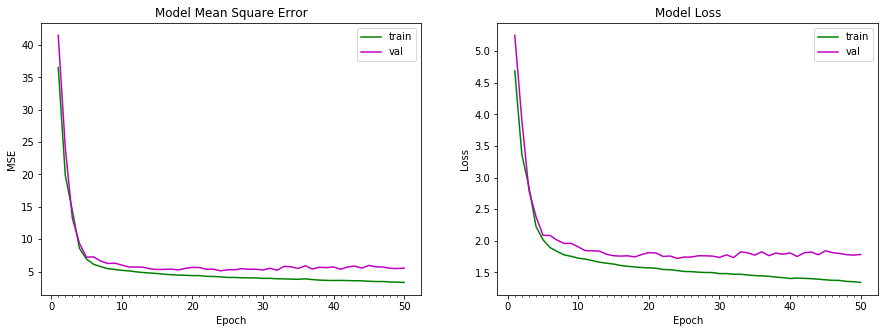

In [0]:
# Single layer LSTM with mostly basic configurations

base_model = Sequential()
base_model.add(CuDNNLSTM(64, input_shape=(48, 4 )))  # 64 neurons
base_model.add(Dense(1, activation ='linear'))  # default activation is linear

opt = 'adam'  # using Adam as optimizer
base_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
base_history = base_model.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50, shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))
print()

# graphing the metrics
plot_model_history(base_history)

In [34]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________




---



#### **Model 2: 1D Convnet + LSTM**


##### **Model 2A: 1D Convnet + LSTM (no RNN for testing)**

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 46, 32)            416       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 737       
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 11s 287us/step - loss: 3.1143 - mean_squared_error: 18.7643 - val_loss: 2.1858 - val_mean_squared_error: 7.7717
Epoch 2/50
38400/38400 [======

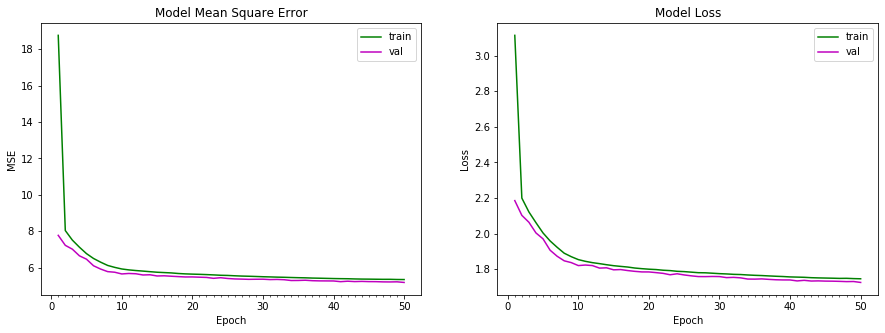

In [0]:
# Model 2A: 1D Convnet and no LSTM.  (simpler of the other models in this group)

model2A = Sequential()
model2A.add(Conv1D(32,  3,  activation='linear',  input_shape=(48,4)))  # Conv1D layer with 32 neurons
model2A.add(MaxPooling1D(2))
model2A.add(Flatten())  # Flatten since it is not followed by an LSTM layer
model2A.add(Dense(1))
model2A.summary()

opt = 'adam'  # optimizer kept at Adam
model2A.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model2A_history = model2A.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50, shuffle=False)  # kept at 50 epochs
end = time.time()
print("model took %0.2f seconds to train" % (end-start))


# graphing the metrics
plot_model_history(model2A_history)



---



##### **Model 2B: 1D Convnet + LSTM (Model 2 best)**


Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 63s 2ms/step - loss: 4.4638 - mean_squared_error: 35.8278 - val_loss: 3.6621 - val_mean_squared_error: 22.7686
Epoch 2/50
38400/38400 [==============================] - 60s 2ms/step - loss: 3.0832 - mean_squared_error: 16.6725 - val_loss: 2.9893 - val_mean_squared_error: 14.5823
Epoch 3/50
38400/38400 [==============================] - 60s 2ms/step - loss: 2.6492 - mean_squared_error: 12.0623 - val_loss: 2.5660 - val_mean_squared_error: 10.7165
Epoch 4/50
38400/38400 [==============================] - 60s 2ms/step - loss: 2.3830 - mean_squared_error: 9.7521 - val_loss: 2.3431 - val_mean_squared_error: 8.9780
Epoch 5/50
38400/38400 [==============================] - 60s 2ms/step - loss: 2.1854 - mean_squared_error: 8.1790 - val_loss: 2.1723 - val_mean_squared_error: 7.7485
Epoch 6/50
38400/38400 [==============================] - 60s 2ms/step - loss: 2.0485 - mean_squared_error: 7

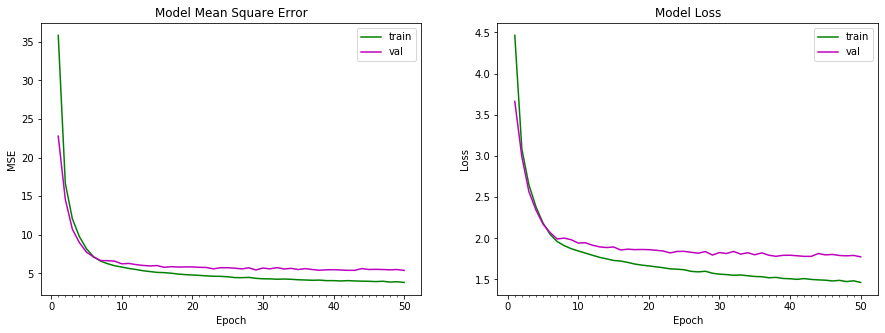

In [0]:
# Model 2B: 1D Convnet + LSTM(32)

model2B = Sequential()
model2B.add(Conv1D(32,  3,  activation='linear',  input_shape=(48,4)))  # same layer as 2A
model2B.add(MaxPooling1D(2))
model2B.add(LSTM(32))  # added LSTM layer
model2B.add(Dense(1))
#model2B.summary()

opt = 'adam'
model2B.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model2B_history = model2B.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50 , shuffle=False)
#odel.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2, shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model2B_history)

In [38]:
model2B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 32)            416       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 2C: 1D Convnet + LSTM + Dropout layer**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 34s 889us/step - loss: 4.1993 - mean_squared_error: 33.0630 - val_loss: 2.9781 - val_mean_squared_error: 14.5081
Epoch 2/50
38400/38400 [==============================] - 27s 704us/step - loss: 2.7354 - mean_squared_error: 12.3582 - val_loss: 2.6520 - val_mean_squared_error: 11.4025
Epoch 3/50
38400/38400 [==============================] - 27s 711us/step - loss: 2.4797 - mean_squared_error: 10.1146 - val_loss: 2.3483 - val_mean_squared_error: 9.0858
Epoch 4/50
38400/38400 [==============================] - 27s 694us/step - loss: 2.3153 - mean_squared_error: 8.9147 - val_loss: 2.3108 - val_mean_squared_error: 8.8472
Epoch 5/50
38400/38400 [==============================] - 27s 698us/step - loss: 2.2316 - mean_squared_error: 8.3528 - val_loss: 2.3249 - val_mean_squared_error: 8.9330
Epoch 6/50
38400/38400 [==============================] - 27s 710us/step - loss: 2.1841 - mean_square

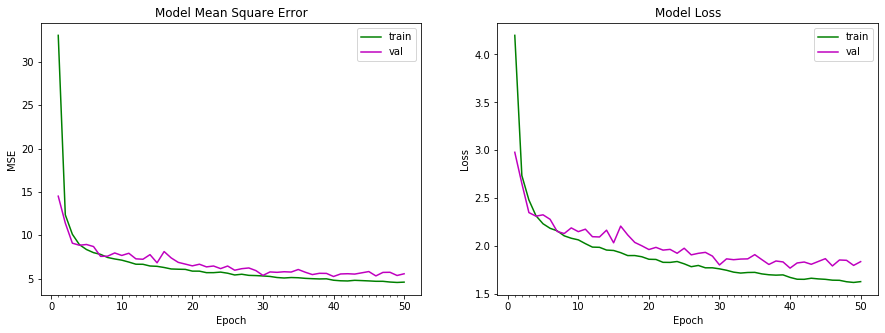

In [0]:
# Model 2C: 1D Convnet + LSTM(32) + Dropout(0.3), batch size of 75, 50 epochs

model2C = Sequential()
model2C.add(Conv1D(32,  3,  activation='linear',  input_shape=(48,4)))
model2C.add(MaxPooling1D(2))
model2C.add(Dropout(0.3))  ## added in this iteration to see how the model is affected
#model2C.add(Flatten())
model2C.add(LSTM( 32, activation='linear'))
model2C.add(Dense(1))


opt = 'adam'  # keep the same
model2C.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model2C_history = model2C.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size = 75, epochs=50 , shuffle=False)  # change batch size to 75 to see how increasing changes the model
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model2C_history)

In [39]:
model2C.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 46, 32)            416       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 2D: 1D Convnet + LSTM + Dropout and Adam(0.0005)**

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 46, 64)            832       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________
Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 24s 635u

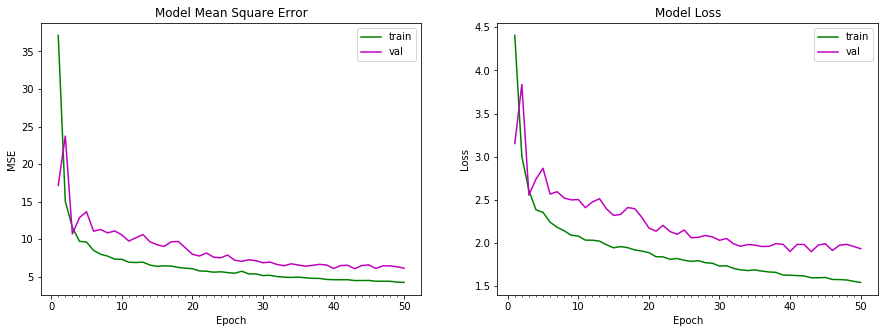

In [0]:
# Model 2D: 1D Convnet + LSTM(32), Adam(0.0005), batch size of 75, 50 epochs

model2D = Sequential()
model2D.add(Conv1D(64,  3,  activation='linear',  input_shape=(48,4)))
model2D.add(MaxPooling1D(2))
model2D.add(Dropout(0.3))
model2D.add(LSTM(64, activation='linear'))
model2D.add(Dense(1))
model2D.summary()

opt = Adam(0.0005)  # updated to use learning rate with Adam
model2D.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model2D_history = model2D.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size = 75, epochs=75 , shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model2D_history)



---



#### **Model 3: LSTM models with different features and architecture**

##### **Model 3A - LSTM model with SGD optimizer**

Train on 38400 samples, validate on 9600 samples
Epoch 1/75
38400/38400 [==============================] - 7s 184us/step - loss: 3.6193 - mean_squared_error: 22.5270 - val_loss: 3.5471 - val_mean_squared_error: 22.9275
Epoch 2/75
38400/38400 [==============================] - 7s 176us/step - loss: 3.1380 - mean_squared_error: 17.5895 - val_loss: 3.1928 - val_mean_squared_error: 18.6833
Epoch 3/75
38400/38400 [==============================] - 7s 177us/step - loss: 2.9931 - mean_squared_error: 15.9672 - val_loss: 3.0074 - val_mean_squared_error: 16.2523
Epoch 4/75
38400/38400 [==============================] - 7s 176us/step - loss: 2.8453 - mean_squared_error: 14.3387 - val_loss: 2.8180 - val_mean_squared_error: 14.0964
Epoch 5/75
38400/38400 [==============================] - 7s 176us/step - loss: 2.5783 - mean_squared_error: 11.7675 - val_loss: 2.3839 - val_mean_squared_error: 10.0311
Epoch 6/75
38400/38400 [==============================] - 7s 176us/step - loss: 2.1409 - mean_squared

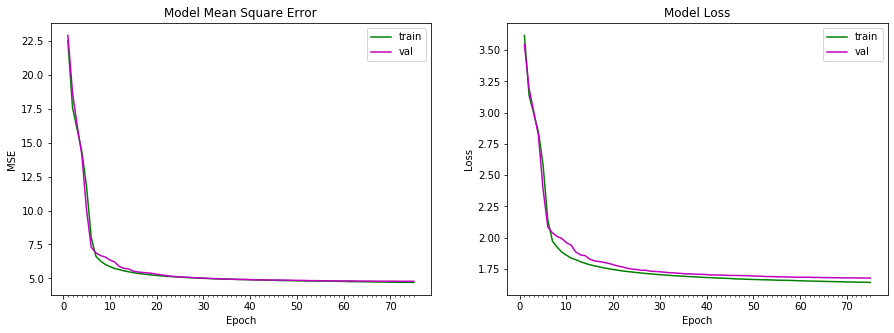

In [0]:
# Model3A, using base model with a differnt optimizer, and adding learning rate...

model3A = Sequential()
model3A.add(CuDNNLSTM(64, input_shape=(48, 4 )))  # using LSTM with 64 neurons
model3A.add(Dense(1, activation ='linear'))

opt = SGD(lr=0.01, momentum=0.9, decay=0.01)  # testing SGD with learning rate and decay, and momentum
model3A.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
model3A_history = model3A.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=75, shuffle=False)  # default batch size but increase epoch to 75
end = time.time()
print("model took %0.2f seconds to train" % (end-start))
print()

# graphing the metrics
plot_model_history(model3A_history)

In [40]:
model3A.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


##### **Model 3B - 2 LSTM layers**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 12s 307us/step - loss: 6.7495 - mean_squared_error: 71.8044 - val_loss: 5.1572 - val_mean_squared_error: 42.0192
Epoch 2/50
38400/38400 [==============================] - 11s 283us/step - loss: 4.5736 - mean_squared_error: 35.5418 - val_loss: 3.4279 - val_mean_squared_error: 20.0112
Epoch 3/50
38400/38400 [==============================] - 11s 284us/step - loss: 3.1507 - mean_squared_error: 17.0543 - val_loss: 2.9176 - val_mean_squared_error: 14.9145
Epoch 4/50
38400/38400 [==============================] - 11s 285us/step - loss: 2.4318 - mean_squared_error: 10.2402 - val_loss: 2.2201 - val_mean_squared_error: 8.2443
Epoch 5/50
38400/38400 [==============================] - 11s 285us/step - loss: 2.1228 - mean_squared_error: 7.7618 - val_loss: 1.9885 - val_mean_squared_error: 6.5578
Epoch 6/50
38400/38400 [==============================] - 11s 286us/step - loss: 2.0458 - mean_squa

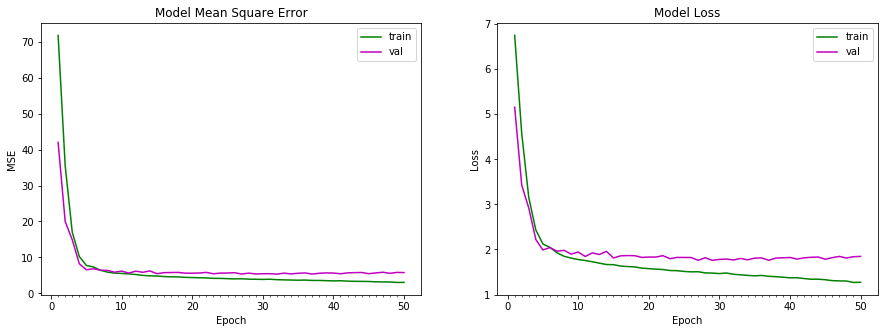

In [0]:
# LSTM Model with Stacked layers using Adam

model3B = Sequential()
model3B.add(CuDNNLSTM(64, input_shape=(48, 4 ), return_sequences=True))  # first LSTM layer with 64 neurons
model3B.add(CuDNNLSTM(64, input_shape=(48, 4 )))  # second LSTM layer with 64 neurons
model3B.add(Dense(1))

opt = 'adam'
model3B.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
model3B_history = model3B.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50, shuffle=False)  # keeping batch size as default and epoch at 50
end = time.time()
print("model took %0.2f seconds to train" % (end-start))
print()

# graphing the metrics
plot_model_history(model3B_history)

In [43]:
model3B.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 48, 64)            17920     
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 64)                33280     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 3C - LSTM with regularizer**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 10s 256us/step - loss: 4.4826 - mean_squared_error: 35.0672 - val_loss: 4.2061 - val_mean_squared_error: 30.0315
Epoch 2/50
38400/38400 [==============================] - 8s 204us/step - loss: 3.2884 - mean_squared_error: 19.0559 - val_loss: 3.3825 - val_mean_squared_error: 19.3432
Epoch 3/50
38400/38400 [==============================] - 8s 202us/step - loss: 2.8540 - mean_squared_error: 14.2992 - val_loss: 2.7728 - val_mean_squared_error: 13.4217
Epoch 4/50
38400/38400 [==============================] - 8s 204us/step - loss: 2.3517 - mean_squared_error: 9.5169 - val_loss: 2.3144 - val_mean_squared_error: 9.3166
Epoch 5/50
38400/38400 [==============================] - 8s 203us/step - loss: 2.0333 - mean_squared_error: 7.0562 - val_loss: 2.1216 - val_mean_squared_error: 7.7323
Epoch 6/50
38400/38400 [==============================] - 8s 206us/step - loss: 1.9249 - mean_squared_er

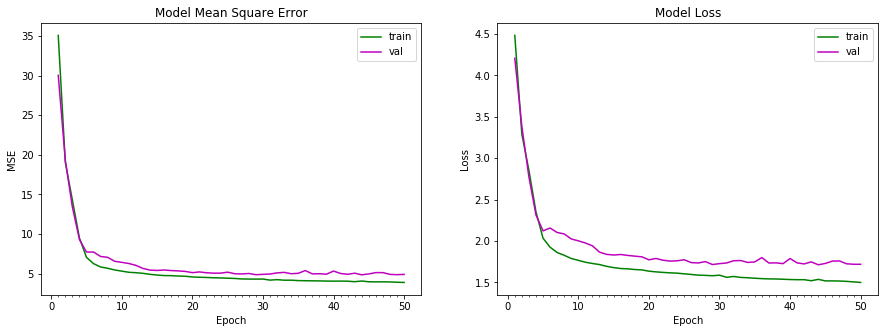

In [0]:
# Model 3C:  LSTM Model with regularizer

model3C = Sequential()
model3C.add(CuDNNLSTM(32, input_shape=(48, 4),  recurrent_regularizer= regularizers.l2(1e-4)))  # addition of regularizer to see how this added hyperparameter affects the overfitting and learning
model3C.add(Dense(1, activation ='linear'))

opt = 'adam'  # keeping Adam without any learning rate since it doesn't seem to take well
model3C.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
model3C_history = model3C.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size =32, epochs=50, shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))
print()

# graphing the metrics
plot_model_history(model3C_history)

In [45]:
model3C.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 32)                4864      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 3D - LSTM with recurrent dropout (Model 3 best)**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 80s 2ms/step - loss: 5.1374 - mean_squared_error: 43.6591 - val_loss: 5.0491 - val_mean_squared_error: 42.5419
Epoch 2/50
38400/38400 [==============================] - 80s 2ms/step - loss: 3.9505 - mean_squared_error: 26.4564 - val_loss: 4.0039 - val_mean_squared_error: 27.6312
Epoch 3/50
38400/38400 [==============================] - 80s 2ms/step - loss: 3.3796 - mean_squared_error: 19.7141 - val_loss: 3.2751 - val_mean_squared_error: 19.2129
Epoch 4/50
38400/38400 [==============================] - 80s 2ms/step - loss: 2.9038 - mean_squared_error: 14.9257 - val_loss: 2.9189 - val_mean_squared_error: 14.5497
Epoch 5/50
38400/38400 [==============================] - 78s 2ms/step - loss: 2.5135 - mean_squared_error: 11.0914 - val_loss: 2.5081 - val_mean_squared_error: 11.3477
Epoch 6/50
38400/38400 [==============================] - 78s 2ms/step - loss: 2.2361 - mean_squared_error

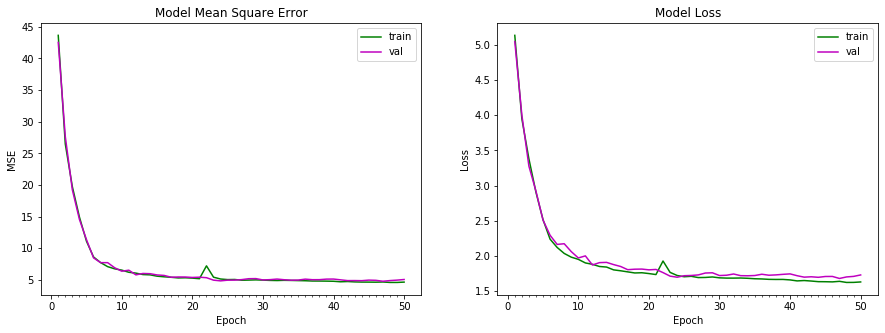

In [0]:
# Model3D: Using recurrent dropout  ## *** best model *** ##

model3D = Sequential()
model3D.add(LSTM(64, return_sequences=False,  recurrent_dropout=0.20, input_shape=(48, 4)))
model3D.add(Dense(1, activation ='linear'))

model3D.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
model3D_history = model3D.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50, batch_size = 50 , shuffle=False)  # keep at 50 for both batch size and epoch
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model3D_history)

In [46]:
model3D.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________




---



#### **Model 4: GRU**

##### **Model 4A - Basic GRU**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 10s 256us/step - loss: 4.5931 - mean_squared_error: 38.5027 - val_loss: 3.6065 - val_mean_squared_error: 22.6744
Epoch 2/50
38400/38400 [==============================] - 6s 159us/step - loss: 3.0187 - mean_squared_error: 16.0338 - val_loss: 3.1054 - val_mean_squared_error: 17.0386
Epoch 3/50
38400/38400 [==============================] - 6s 157us/step - loss: 2.7181 - mean_squared_error: 12.8677 - val_loss: 2.9358 - val_mean_squared_error: 15.0628
Epoch 4/50
38400/38400 [==============================] - 6s 161us/step - loss: 2.3985 - mean_squared_error: 9.9363 - val_loss: 2.3031 - val_mean_squared_error: 9.1484
Epoch 5/50
38400/38400 [==============================] - 6s 162us/step - loss: 2.1044 - mean_squared_error: 7.5308 - val_loss: 2.0984 - val_mean_squared_error: 7.5408
Epoch 6/50
38400/38400 [==============================] - 6s 160us/step - loss: 1.9431 - mean_squared_er

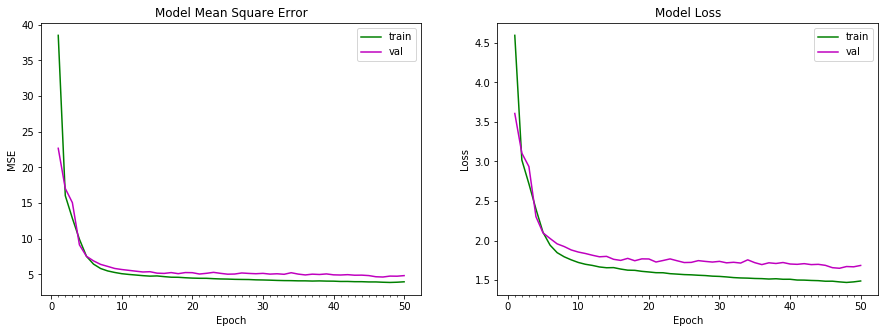

In [0]:
# Model 4A - basic GRU

model4A = Sequential()
model4A.add(CuDNNGRU(32, input_shape=(48,4)))  # using speedier CuDNNGRU for processing
model4A.add(Dense(1, activation ='linear'))

opt = 'adam'  # keep as adam
model4A.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# Training the model (computation time calculated)
start = time.time()
model4A_history = model4A.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=50 , shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model4A_history)

In [49]:
model4A.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_3 (CuDNNGRU)       (None, 32)                3648      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 4B - GRU with Adam(0.0005)**

Train on 38400 samples, validate on 9600 samples
Epoch 1/75
38400/38400 [==============================] - 16s 420us/step - loss: 5.4053 - mean_squared_error: 52.6683 - val_loss: 4.0732 - val_mean_squared_error: 29.4947
Epoch 2/75
38400/38400 [==============================] - 13s 337us/step - loss: 3.3589 - mean_squared_error: 20.1990 - val_loss: 3.2891 - val_mean_squared_error: 19.3137
Epoch 3/75
38400/38400 [==============================] - 13s 338us/step - loss: 2.9870 - mean_squared_error: 15.6639 - val_loss: 3.0174 - val_mean_squared_error: 16.0779
Epoch 4/75
38400/38400 [==============================] - 13s 337us/step - loss: 2.8269 - mean_squared_error: 13.9012 - val_loss: 2.8702 - val_mean_squared_error: 14.3720
Epoch 5/75
38400/38400 [==============================] - 13s 337us/step - loss: 2.7166 - mean_squared_error: 12.7775 - val_loss: 2.7504 - val_mean_squared_error: 12.9418
Epoch 6/75
38400/38400 [==============================] - 13s 337us/step - loss: 2.6111 - mean_s

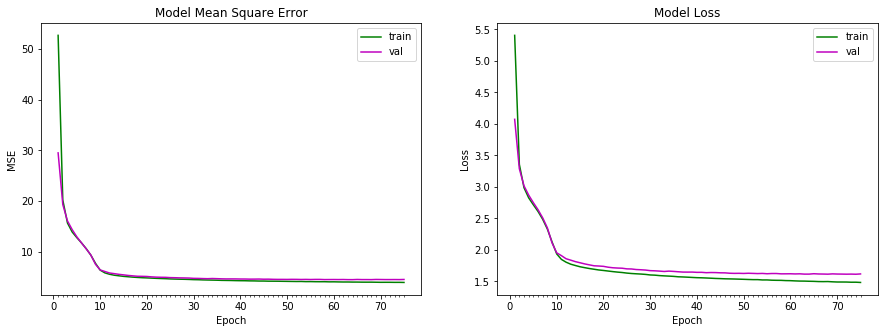

In [0]:
# Model 4B: 4A + change in adam learning rate


model4B = Sequential()
model4B.add(CuDNNGRU(32, input_shape=(48,4)))
model4B.add(Dense(1, activation ='linear'))

opt = Adam(0.0005)  ## added to this iteration
model4B.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model4B_history = model4B.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=75 , shuffle=False)  # increasing the epochs here to see what happens when increasing the number of epochs for training
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model4B_history)

In [50]:
model4B.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 32)                3648      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 4C - GRU with Adam(0.0005) and increased batch size and epoch (Model 4 best)**

Train on 38400 samples, validate on 9600 samples
Epoch 1/75
38400/38400 [==============================] - 7s 180us/step - loss: 6.5471 - mean_squared_error: 71.6805 - val_loss: 5.1897 - val_mean_squared_error: 45.5331
Epoch 2/75
38400/38400 [==============================] - 4s 94us/step - loss: 4.2223 - mean_squared_error: 31.0944 - val_loss: 4.0209 - val_mean_squared_error: 29.1892
Epoch 3/75
38400/38400 [==============================] - 4s 92us/step - loss: 3.5843 - mean_squared_error: 22.9494 - val_loss: 3.5571 - val_mean_squared_error: 22.8685
Epoch 4/75
38400/38400 [==============================] - 4s 94us/step - loss: 3.2567 - mean_squared_error: 18.8990 - val_loss: 3.3313 - val_mean_squared_error: 19.8793
Epoch 5/75
38400/38400 [==============================] - 4s 95us/step - loss: 3.0808 - mean_squared_error: 16.7317 - val_loss: 3.1826 - val_mean_squared_error: 17.9297
Epoch 6/75
38400/38400 [==============================] - 4s 94us/step - loss: 2.9651 - mean_squared_erro

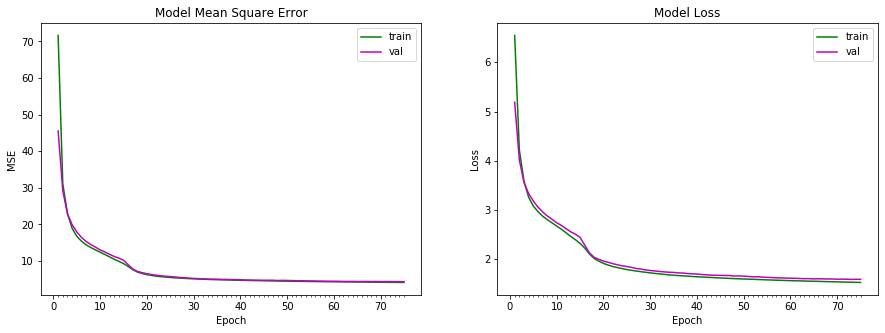

In [0]:
# Model 4C: 4B + increase in batch size (Default to 75) + change in learning rate to 0.001


model4C = Sequential()
model4C.add(CuDNNGRU(32, input_shape=(48,4)))
model4C.add(Dense(1, activation ='linear'))

opt = Adam(0.0005)  # addition of learning rate for this version of model 4
model4C.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model4C_history = model4C.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size = 75, epochs=75 , shuffle=False)  # keeping epoch and batch size at 75.  appears to do well
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model4C_history)

In [52]:

model4C.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_6 (CuDNNGRU)       (None, 32)                3648      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 4D - GRU with stacked layers and dropout layer**

Train on 38400 samples, validate on 9600 samples
Epoch 1/75
38400/38400 [==============================] - 14s 370us/step - loss: 5.1643 - mean_squared_error: 48.3205 - val_loss: 3.9901 - val_mean_squared_error: 28.8556
Epoch 2/75
38400/38400 [==============================] - 11s 277us/step - loss: 3.4351 - mean_squared_error: 21.0057 - val_loss: 3.4823 - val_mean_squared_error: 21.7136
Epoch 3/75
38400/38400 [==============================] - 11s 276us/step - loss: 3.0401 - mean_squared_error: 16.3177 - val_loss: 3.0854 - val_mean_squared_error: 17.1075
Epoch 4/75
38400/38400 [==============================] - 11s 277us/step - loss: 2.7343 - mean_squared_error: 13.0617 - val_loss: 2.8024 - val_mean_squared_error: 14.2687
Epoch 5/75
38400/38400 [==============================] - 11s 279us/step - loss: 2.4049 - mean_squared_error: 10.0099 - val_loss: 2.3851 - val_mean_squared_error: 10.0560
Epoch 6/75
38400/38400 [==============================] - 11s 278us/step - loss: 2.1300 - mean_s

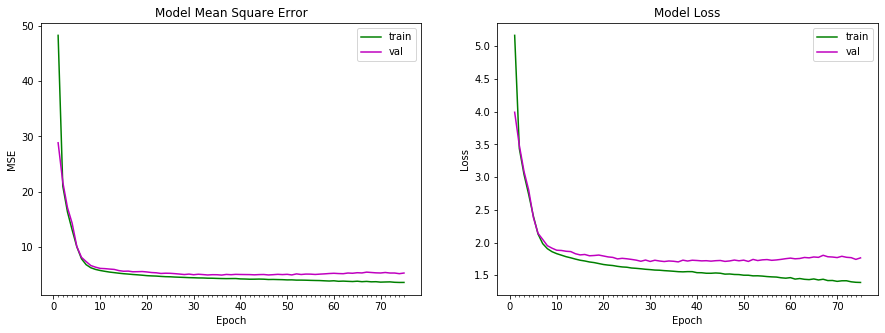

In [0]:
# Model 4D: 2C + stacked recurrent layers and dropout

model4D = Sequential()
model4D.add(CuDNNGRU(32, input_shape=(48,4), return_sequences=True))  # GRU layer 1 for 32 neurons
model4D.add(CuDNNGRU(32, input_shape=(48,4)))  # GRU layer 2 for 32 neurons
model4D.add(Dropout(0.3))  # included but doesn't seem to help
model4D.add(Dense(1, activation ='linear'))

opt = Adam(0.001)
model4D.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model4D_history = model4D.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), epochs=75, shuffle=False)
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model4D_history)

In [53]:
model4D.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_7 (CuDNNGRU)       (None, 48, 32)            3648      
_________________________________________________________________
cu_dnngru_8 (CuDNNGRU)       (None, 32)                6336      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________




---



##### **Model 4D - GRU with stacked layers and dropout layer**

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 55s 1ms/step - loss: 5.7398 - mean_squared_error: 54.8236 - val_loss: 4.5472 - val_mean_squared_error: 34.7021
Epoch 2/50
38400/38400 [==============================] - 50s 1ms/step - loss: 4.2257 - mean_squared_error: 29.6204 - val_loss: 3.6857 - val_mean_squared_error: 23.7149
Epoch 3/50
38400/38400 [==============================] - 52s 1ms/step - loss: 3.7158 - mean_squared_error: 23.4925 - val_loss: 3.3056 - val_mean_squared_error: 19.4346
Epoch 4/50
38400/38400 [==============================] - 52s 1ms/step - loss: 3.3811 - mean_squared_error: 19.5350 - val_loss: 3.0526 - val_mean_squared_error: 16.5432
Epoch 5/50
38400/38400 [==============================] - 50s 1ms/step - loss: 3.2208 - mean_squared_error: 17.8307 - val_loss: 2.8753 - val_mean_squared_error: 14.6706
Epoch 6/50
38400/38400 [==============================] - 51s 1ms/step - loss: 3.1562 - mean_squared_error

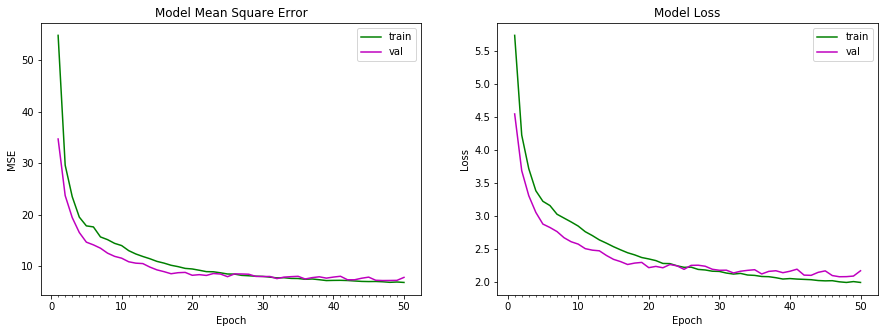

In [0]:
# Model 2e: 2b + stacked recurrent layers and dropout
# 3 layers

model4E = Sequential()
model4E.add(GRU(64, dropout=0.2, recurrent_dropout=0.3, input_shape=(48,4)))  # added dropout in addition to the recurrent dropout.
model4E.add(Dense(1, activation ='linear'))

opt = Adam(0.0005)  # keep the learning rate to test
model4E.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])


# Training the model (computation time calculated)
start = time.time()
model4E_history = model4E.fit(scale_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size = 50, epochs=50 , shuffle=False)  # keeping the batch size and epoch at 50
end = time.time()
print("model took %0.2f seconds to train" % (end-start))

# graphing the metrics
plot_model_history(model4E_history)

In [54]:
model4E.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                13248     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________




---



### **Conclusion**

Based on the Kaggle competition and the evaluation metrics, the best model is Model 4, the GRU model with the tuned hyperparameters.  Please see final paper for tables and figures.



---



### **Predictions and saving submission file**

In [0]:
predictions = model.predict(scale_x_test)

In [0]:
predicted = pd.read_csv('sample_submission_2019fall.csv', header=0, index_col=0)
predicted['temperature']=predictions
predicted.to_csv('1123_1.csv')

Iteration of learning rate:

Finding the learning rate for the Adam optimizer through iterations.  The ideal learning rate for Adam is 0.0005.


Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 12s 312us/step - loss: 4.9569 - mean_squared_error: 39.1539 - val_loss: 6.5869 - val_mean_squared_error: 65.0283
Epoch 2/30
38400/38400 [==============================] - 8s 218us/step - loss: 5.0090 - mean_squared_error: 41.4437 - val_loss: 6.5805 - val_mean_squared_error: 64.9091
Epoch 3/30
38400/38400 [==============================] - 9s 223us/step - loss: 5.0075 - mean_squared_error: 41.4353 - val_loss: 6.4641 - val_mean_squared_error: 62.7134
Epoch 4/30
38400/38400 [==============================] - 8s 217us/step - loss: 4.9910 - mean_squared_error: 41.1190 - val_loss: 6.4847 - val_mean_squared_error: 63.1023
Epoch 5/30
38400/38400 [==============================] - 8s 219us/step - loss: 4.9934 - mean_squared_error: 41.1634 - val_loss: 6.5658 - val_mean_squared_error: 64.6302
Epoch 6/30
38400/38400 [==============================] - 8s 219us/step - loss: 5.0035 - mean_square

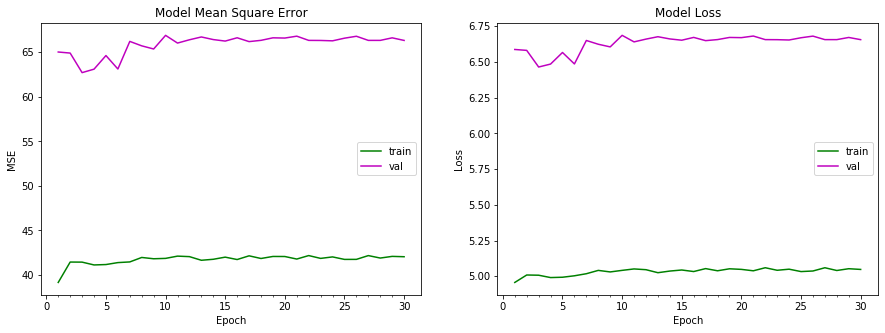

Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 12s 314us/step - loss: 5.0735 - mean_squared_error: 41.9256 - val_loss: 4.9239 - val_mean_squared_error: 39.3174
Epoch 2/30
38400/38400 [==============================] - 8s 215us/step - loss: 3.7812 - mean_squared_error: 24.5200 - val_loss: 3.8857 - val_mean_squared_error: 24.7176
Epoch 3/30
38400/38400 [==============================] - 8s 218us/step - loss: 3.4243 - mean_squared_error: 20.1948 - val_loss: 3.5406 - val_mean_squared_error: 21.2037
Epoch 4/30
38400/38400 [==============================] - 8s 216us/step - loss: 3.0805 - mean_squared_error: 16.5650 - val_loss: 3.3674 - val_mean_squared_error: 19.1791
Epoch 5/30
38400/38400 [==============================] - 8s 218us/step - loss: 2.8668 - mean_squared_error: 14.4199 - val_loss: 3.0883 - val_mean_squared_error: 15.9275
Epoch 6/30
38400/38400 [==============================] - 8s 216us/step - loss: 2.4529 - mean_square

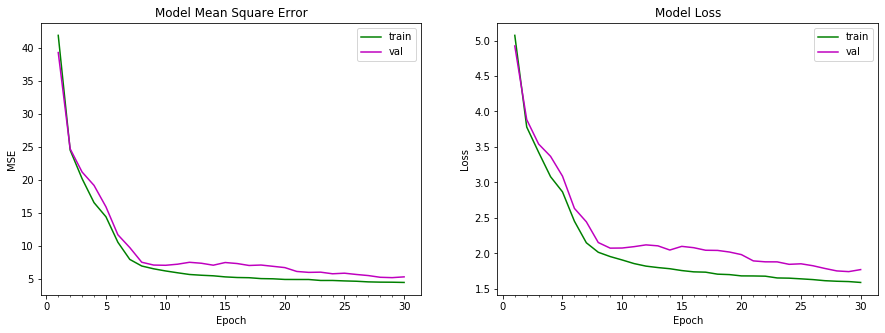

Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 13s 328us/step - loss: 4.6012 - mean_squared_error: 35.0981 - val_loss: 5.7841 - val_mean_squared_error: 50.5834
Epoch 2/30
38400/38400 [==============================] - 8s 220us/step - loss: 3.4176 - mean_squared_error: 20.5031 - val_loss: 3.3261 - val_mean_squared_error: 18.7142
Epoch 3/30
38400/38400 [==============================] - 8s 217us/step - loss: 2.8982 - mean_squared_error: 15.0551 - val_loss: 3.0886 - val_mean_squared_error: 15.9557
Epoch 4/30
38400/38400 [==============================] - 8s 220us/step - loss: 2.7128 - mean_squared_error: 13.3019 - val_loss: 3.0373 - val_mean_squared_error: 15.6574
Epoch 5/30
38400/38400 [==============================] - 8s 221us/step - loss: 2.5680 - mean_squared_error: 11.8156 - val_loss: 2.6876 - val_mean_squared_error: 12.7190
Epoch 6/30
38400/38400 [==============================] - 8s 220us/step - loss: 2.2944 - mean_square

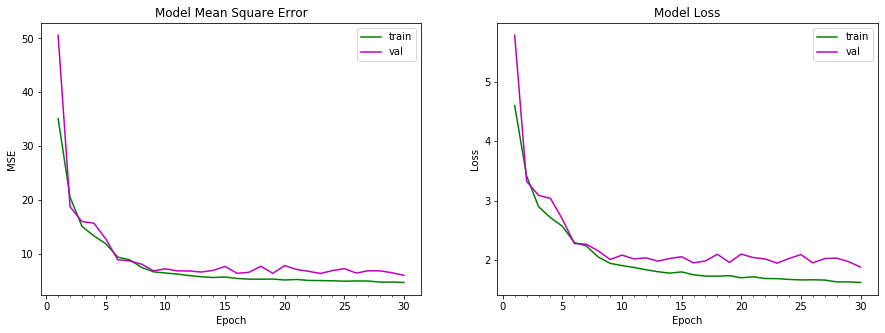

Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 12s 320us/step - loss: 5.9104 - mean_squared_error: 61.7109 - val_loss: 4.4468 - val_mean_squared_error: 33.6404
Epoch 2/30
38400/38400 [==============================] - 8s 220us/step - loss: 3.8301 - mean_squared_error: 25.9445 - val_loss: 3.6544 - val_mean_squared_error: 23.3737
Epoch 3/30
38400/38400 [==============================] - 8s 220us/step - loss: 3.4659 - mean_squared_error: 20.9921 - val_loss: 3.3828 - val_mean_squared_error: 19.4774
Epoch 4/30
38400/38400 [==============================] - 8s 221us/step - loss: 3.2930 - mean_squared_error: 18.7826 - val_loss: 3.1875 - val_mean_squared_error: 17.5638
Epoch 5/30
38400/38400 [==============================] - 9s 221us/step - loss: 3.1475 - mean_squared_error: 17.2262 - val_loss: 3.0122 - val_mean_squared_error: 15.5544
Epoch 6/30
38400/38400 [==============================] - 9s 223us/step - loss: 3.0406 - mean_square

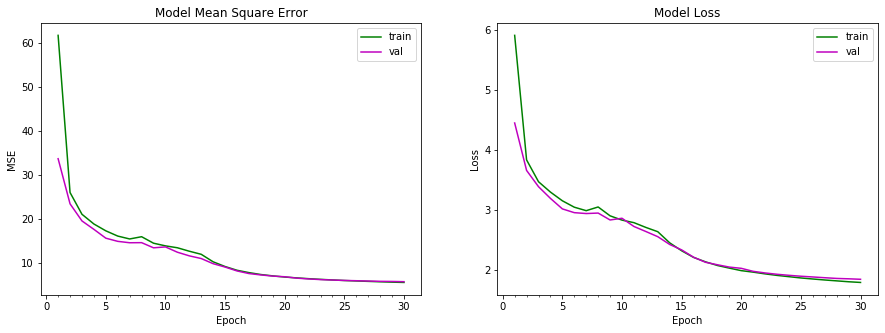

Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 13s 330us/step - loss: 4.8255 - mean_squared_error: 39.3520 - val_loss: 4.7191 - val_mean_squared_error: 35.3228
Epoch 2/30
38400/38400 [==============================] - 9s 225us/step - loss: 3.6549 - mean_squared_error: 23.4519 - val_loss: 3.9949 - val_mean_squared_error: 26.0415
Epoch 3/30
38400/38400 [==============================] - 9s 224us/step - loss: 3.0124 - mean_squared_error: 16.0974 - val_loss: 2.9385 - val_mean_squared_error: 14.8108
Epoch 4/30
38400/38400 [==============================] - 9s 226us/step - loss: 2.2862 - mean_squared_error: 9.0494 - val_loss: 2.2879 - val_mean_squared_error: 8.7003
Epoch 5/30
38400/38400 [==============================] - 9s 233us/step - loss: 2.0268 - mean_squared_error: 7.0699 - val_loss: 2.1671 - val_mean_squared_error: 7.8015
Epoch 6/30
38400/38400 [==============================] - 9s 223us/step - loss: 1.9308 - mean_squared_er

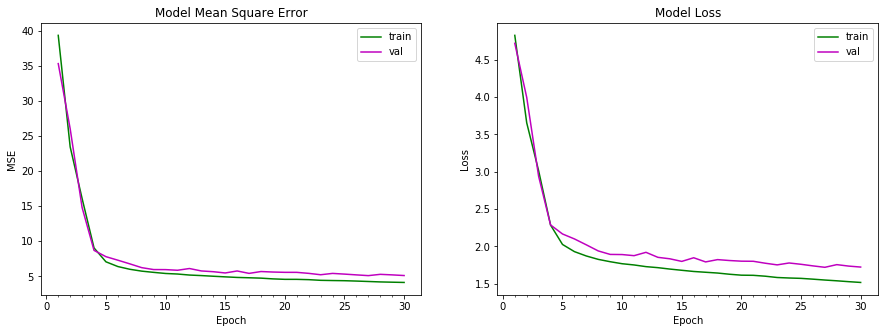

In [0]:
lr = [0.1, 0.001, 0.005, 0.0001, 0.0005]

for i in lr:
  model2_lr = Sequential()
  model2_lr.add(CuDNNLSTM(64, input_shape=(48, 4)))
  model2_lr.add(Dense(1, activation ='linear'))

  opt = Adam(i)
  model2_lr.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

  # Training the model (computation time calculated)
  start = time.time()
  m2_lr_history = model2_lr.fit(scale_x_train, y_train, validation_data=(scale_x_valid, y_valid), batch_size=32, epochs=30, shuffle=False)
  end = time.time()
  print("learning rate:",i)
  print("model took %0.2f seconds to train" % (end-start))
  print()

  # graphing the metrics
  plot_model_history(m2_lr_history)